In [ ]:
import os
import glob
import shutil
import librosa
import soundfile as sf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [ ]:
import tensorflow as tf
import keras
import torch
from keras import layers, models ,Model ,Input
from keras.layers import Dense, Flatten, Activation, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
Train_Dir = '/content/gdrive/MyDrive/VoiceRecognition/data/Train/'
Test_Dir = '/content/gdrive/MyDrive/VoiceRecognition/data/Test/'

In [ ]:
def MFCC(audio_path):
  path = audio_path
  sample_rate = 16000

  x = librosa.load(path,sample_rate)[0]
  S = librosa.feature.melspectrogram(x, sr=sample_rate, n_mels=128)
  log_S = librosa.power_to_db(S, ref=np.max)
  mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20)

  delta2_mfcc = librosa.feature.delta(mfcc, order=2)

  return mfcc, delta2_mfcc

In [ ]:
def padding(list,*array) :
 max = 0
 for i in range(len(list)):
    if max == 0 or list[i].shape[1] > max :
      max = list[i].shape[1]
 for i in range(len(list)):
   addnum = max - list[i].shape[1]
   list[i] = np.pad(list[i], [(0, 0), (0, addnum)], mode='constant')
 for i in array:
   for j in range(len(list)):
     if str(type(i)) == "<class 'numpy.ndarray'>" :
       addnum = i[0].shape[1] - list[j].shape[1]
       if addnum >= 0:
         list[j] = np.pad(list[j], [(0, 0), (0, addnum)], mode='constant')
       else :
         list[j] = list[j][:,0:i[0].shape[1]]
     elif str(type(i)) == "<class 'keras.engine.keras_tensor.KerasTensor'>" :
       addnum = i.shape[2] - list[j].shape[1]
       if addnum >= 0:
         list[j] = np.pad(list[j], [(0, 0), (0, addnum)], mode='constant')
       else :
         list[j] = list[j][:,0:i.shape[2]]
     elif str(type(i)) == "<class 'tuple'>" :
       addnum = i[1] - list[j].shape[1]
       if addnum >= 0:
         list[j] = np.pad(list[j], [(0, 0), (0, addnum)], mode='constant')
       else :
         list[j] = list[j][:,0:i[1]]

In [ ]:
def fulldataLearn(newDataDir):
  data = []
  target = []
  data2 = []
  target2 = []
  Train_Dir = '/content/gdrive/MyDrive/VoiceRecognition/data/Train/'
  
  for i, (root, dirs, files) in enumerate (os.walk(Train_Dir)):
    for file in files :
      if '.wav'  not in file in file :
        continue
      else :
        audio_path = os.path.join(root,file)
        mfcc, delta = MFCC(audio_path)
        mfcc = mfcc.astype(float)
        dirname = os.path.dirname(audio_path) 
        data.append(mfcc)
        target.append(dirname)

  for i, (root, dirs, files) in enumerate (os.walk(newDataDir)):
      for file in files :
        if '.wav'  not in file in file :
          continue
        else :
          audio_path = os.path.join(root,file)
          mfcc, delta = MFCC(audio_path)
          mfcc = mfcc.astype(float)
          dirname = os.path.dirname(audio_path) 
          data.append(mfcc)
          target.append(dirname)
  
  padding(data)
  data = np.array(data)

  encoder = LabelEncoder()
  encoder.fit(target)
  target_encoded = encoder.transform(target)

  target = tf.keras.utils.to_categorical(np.array(target_encoded))

  print(data.shape)
  print(target.shape)

  train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.4, shuffle=True, stratify=target, random_state=42)
  test_x, val_x, test_y, val_y = train_test_split(val_x, val_y, random_state=42, test_size=0.5, stratify=val_y)

  train_x = np.expand_dims(train_x, -1)
  test_x = np.expand_dims(test_x, -1)
  val_x = np.expand_dims(val_x, -1)

  model = CNN(train_x)
  net = Dense(target.shape[1], activation='softmax' ,name="dense_a")(model.layers[-2].output)
  model = Model(inputs = model.input, outputs = net)

  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  model.fit(train_x,
            train_y,
            epochs=50,
            batch_size=32,
            verbose=1,
            validation_data=(val_x, val_y))

  return model

In [ ]:
class Data_augmentation:
  def __init__(self, filepath, num):
    self.filepath = filepath
    self.num = num
  def whiteNoise(self, signal, noise_rate):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_rate
    return augmented_signal
  def timeStretch(self, signal, stretch_rate):
    return librosa.effects.time_stretch(signal, stretch_rate)
  def pitchScaling(self, signal, sr, pitch_step):
    return librosa.effects.pitch_shift(signal, sr, pitch_step)
  def reverse(self, signal):
    return signal * -1

In [ ]:
data = []
target = []

for i, (root, dirs, files) in enumerate (os.walk(Train_Dir)):
  for file in files :
    if '.wav'  not in file in file :
      continue
    else :
      audio_path = os.path.join(root,file)
      mfcc, delta = MFCC(audio_path)
      mfcc = mfcc.astype(float)
      dirname = os.path.dirname(audio_path) 
      data.append(mfcc)
      target.append(dirname)

In [ ]:
padding(data)
data = np.array(data)

encoder = LabelEncoder()
encoder.fit(target)
target_encoded = encoder.transform(target)
print(target, '==>', target_encoded)

target = tf.keras.utils.to_categorical(np.array(target_encoded))

['/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecogniti

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.4, shuffle=True, stratify=target, random_state=42)
test_x, val_x, test_y, val_y = train_test_split(val_x, val_y, random_state=42, test_size=0.5, stratify=val_y)

In [ ]:
print('train_x type :', type(train_x), 'train_y type', type(train_y))
print('test_x type :', type(test_x), 'test_y type', type(test_y))
print('train_x shape :', train_x.shape, 'train_y shape', train_y.shape)
print('test_x shape :', test_x.shape, 'test_y shape', test_y.shape)
print('val_x shape :', val_x.shape, 'val_y shape', val_y.shape)

train_x type : <class 'numpy.ndarray'> train_y type <class 'numpy.ndarray'>
test_x type : <class 'numpy.ndarray'> test_y type <class 'numpy.ndarray'>
train_x shape : (1200, 20, 262) train_y shape (1200, 20)
test_x shape : (400, 20, 262) test_y shape (400, 20)
val_x shape : (400, 20, 262) val_y shape (400, 20)


In [ ]:
train_x = np.expand_dims(train_x, -1)
test_x = np.expand_dims(test_x, -1)
val_x = np.expand_dims(val_x, -1)

In [ ]:
# hyper parameters

# learning_rate = 
# epochs = 100
# batch_size = 32

In [ ]:
def CNN(train_x):   
    input = Input(shape=train_x[0].shape)
    
    hidden1 = layers.Conv2D(32, (3, 3), padding='same',strides = (2,2),activation='relu')(input)

    hidden2 = layers.Conv2D(32*2, (3, 3), padding='same',strides = (2,2), activation='relu')(hidden1)
    
    hidden3 = layers.Conv2D(32*3, (3, 3), padding='same',strides = (2,2),activation='relu')(hidden2)

    hidden4 = layers.Conv2D(32*4, (3, 3), padding='same',strides = (2,2),activation='relu')(hidden3)

    hidden5 = layers.Conv2D(32*5, (3, 3), padding='same',strides = (2,2),activation='relu')(hidden4)

    hidden = Flatten()(hidden5)
    hidden = layers.BatchNormalization()(hidden)
    hidden = Dense(32, activation='relu')(hidden)

    output = Dense(20, activation='softmax')(hidden)

    model = Model(input, output)

    return model

In [ ]:
model2 = models.load_model('/content/gdrive/MyDrive/model/best_model.h5')
model2.summary()
print(type(model2.input))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 262, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 10, 131, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 66, 64)         18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 33, 96)         55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 17, 128)        110720    
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 9, 160)         184480    
                                                                 
 flatten (Flatten)           (None, 1440)              0     

In [ ]:
model = CNN(train_x)
print(type(CNN(train_x).input))
net = Dense(target.shape[1], activation='softmax' ,name="dense_a")(model.layers[-2].output)
model = Model(inputs = model.input, outputs = net)
model.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
Model: "model_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_124 (InputLayer)      [(None, 20, 262, 1)]      0         
                                                                 
 conv2d_615 (Conv2D)         (None, 10, 131, 32)       320       
                                                                 
 conv2d_616 (Conv2D)         (None, 5, 66, 64)         18496     
                                                                 
 conv2d_617 (Conv2D)         (None, 3, 33, 96)         55392     
                                                                 
 conv2d_618 (Conv2D)         (None, 2, 17, 128)        110720    
                                                                 
 conv2d_619 (Conv2D)         (None, 1, 9, 160)         184480    
                                                                 
 flatten_

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10),
             keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/model/best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hist = model.fit(train_x,
          train_y,
          epochs=50,
          batch_size=32,
          verbose=1,
          validation_data=(val_x, val_y),
          callbacks = callbacks)

model2 = models.load_model('/content/gdrive/MyDrive/model/best_model.h5')

Epoch 1/50
38/38 [==============================] - 7s 158ms/step - loss: 1.6454 - accuracy: 0.5525 - val_loss: 4.8148 - val_accuracy: 0.2200
Epoch 2/50
38/38 [==============================] - 5s 138ms/step - loss: 0.3940 - accuracy: 0.9250 - val_loss: 1.8553 - val_accuracy: 0.4750
Epoch 3/50
38/38 [==============================] - 5s 142ms/step - loss: 0.1264 - accuracy: 0.9842 - val_loss: 0.4665 - val_accuracy: 0.8725
Epoch 4/50
38/38 [==============================] - 5s 138ms/step - loss: 0.0580 - accuracy: 0.9958 - val_loss: 0.1684 - val_accuracy: 0.9575
Epoch 5/50
38/38 [==============================] - 5s 143ms/step - loss: 0.0259 - accuracy: 0.9983 - val_loss: 0.0896 - val_accuracy: 0.9775
Epoch 6/50
38/38 [==============================] - 5s 142ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9850
Epoch 7/50
38/38 [==============================] - 5s 141ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0536 - val_accuracy: 0.9850
Epoch 

In [ ]:
score = model.evaluate(val_x, val_y, verbose=2)
print('Accuracy=',score[1],'Loss=',score[0])

13/13 - 0s - loss: 0.0249 - accuracy: 0.9925 - 398ms/epoch - 31ms/step
Accuracy= 0.9925000071525574 Loss= 0.024880697950720787


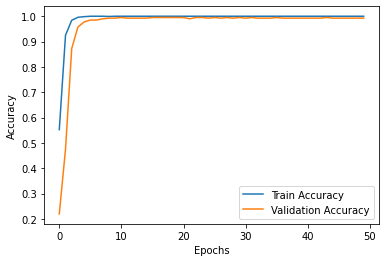

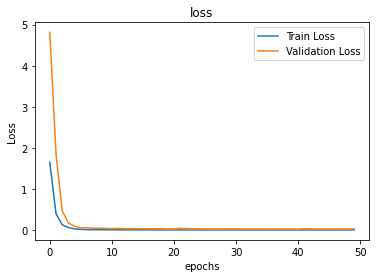

In [ ]:
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve

def get_eval(test_y, pred):
  confusion = confusion_matrix(test_y, pred)
  accuracy = accuracy_score(test_y, pred)
  pre_macro = precision_score(test_y, pred, average='macro')
  pre_micro = precision_score(test_y, pred, average='micro')
  recall_macro = recall_score(test_y, pred, average='macro')
  recall_micro = recall_score(test_y, pred, average='micro')
  f1macro = f1_score(test_y, pred, average='macro')
  f1micro = f1_score(test_y, pred, average='micro')

  fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
  fnr = 1 - tpr
  eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

  EER = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

  print('Confusion Matrix')
  print(confusion)
  print('Accuracy:{}' .format(accuracy))
  print('Precision(Macro):{}, Recall(Macro):{}'.format(pre_macro, recall_macro))
  print('Precision(Micro):{}, Recall(Micro):{}'.format(pre_micro, recall_micro))
  print('F1-Score(Macro) : {}, F1-Score(Micro) : {}' .format(f1macro, f1micro))

In [ ]:
pred =np.argmax(model.predict(test_x) , axis=-1)
test_y2 = np.argmax(test_y, axis=-1)

In [ ]:
print('test_y type :', type(test_y2), 'pred type', type(pred))
get_eval(test_y2, pred)

test_y type : <class 'numpy.ndarray'> pred type <class 'numpy.ndarray'>
Confusion Matrix
[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 19  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 

In [ ]:
fulldataLearn('/content/gdrive/MyDrive/augmentation/')

(2121, 20, 262)
(2121, 24)
Model: "model_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_126 (InputLayer)      [(None, 20, 262, 1)]      0         
                                                                 
 conv2d_625 (Conv2D)         (None, 10, 131, 32)       320       
                                                                 
 conv2d_626 (Conv2D)         (None, 5, 66, 64)         18496     
                                                                 
 conv2d_627 (Conv2D)         (None, 3, 33, 96)         55392     
                                                                 
 conv2d_628 (Conv2D)         (None, 2, 17, 128)        110720    
                                                                 
 conv2d_629 (Conv2D)         (None, 1, 9, 160)         184480    
                                                                 
 flatten_125 (Flatten)       (